# Arizona Coyotes - Default Retention Model
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Jan 14, 2022

## Hypothesis
This notebook contains the data pre-processing, model training and evaluation of the Coyotes retention model with the default StellarAlgo features. We think that the distToVenue feature could be a significant indicator for Full Season ticket buyers.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [32]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *
from ngboost import NGBClassifier

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [34]:
# connect to SQL Server.
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password ··················


In [35]:
lkupclientid = 55 # coyotes
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrCoyotes].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(17399, 55)

### Let's specify the default SA features for our model:

In [64]:
# choose the features for the stellar base retention model
features = [
    "dimCustomerMasterId",
    "attendancePercent",
    "distToVenue",
    "isNextYear_Buyer",
    "productGrouping",
    "recency",
    "source_tenure",
    "totalSpent",
    "year"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (11598, 9)
Unseen Data For Predictions: (2047, 9)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [65]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
        "attendancePercent",
        "distToVenue",
        "recency",
        "source_tenure",
        "totalSpent"
    ]
);

### Let's compare all models to evaluate performance. The output prints a score grid that shows average Accuracy, AUC, Recall, Precision, F1 and Kappa accross the folds (10 by default) along with training time:

In [67]:
# adding an extra classifier ngboost
ngc = NGBClassifier()
ngboost = create_model(ngc)

model_matrix = compare_models(
    fold=10,
    include=["gbc", "lightgbm", "lr", ngboost, "rf", "xgboost"],
    sort="AUC"
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
1,Light Gradient Boosting Machine,0.7159,0.7623,0.5612,0.6649,0.6085,0.3881,0.3916,0.5880
0,Gradient Boosting Classifier,0.7118,0.7597,0.5692,0.6543,0.6086,0.3823,0.3848,0.0900
5,Extreme Gradient Boosting,0.7119,0.7584,0.5597,0.6578,0.6046,0.3803,0.3835,0.3240
3,NGBClassifier,0.7061,0.7521,0.5643,0.6451,0.6018,0.3706,0.3728,1.5670
4,Random Forest Classifier,0.6900,0.7357,0.5491,0.6198,0.5822,0.3373,0.3389,0.2230
2,Logistic Regression,0.6314,0.5950,0.2321,0.5729,0.3051,0.1335,0.1568,0.0120


### Now that we have the best performing model, we can finalize it:

In [68]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7008,0.7604,0.5270,0.6487,0.5816,0.3526,0.3572
1,0.7028,0.7519,0.5541,0.6418,0.5947,0.3621,0.3646
2,0.7170,0.7500,0.5515,0.6708,0.6054,0.3881,0.3926
3,0.7333,0.7715,0.5902,0.6877,0.6352,0.4269,0.4300
4,0.7150,0.7558,0.5464,0.6688,0.6014,0.3831,0.3879
5,0.7353,0.7774,0.6134,0.6819,0.6459,0.4355,0.4370
6,0.7231,0.7650,0.5515,0.6837,0.6106,0.3996,0.4051
7,0.7170,0.7668,0.5567,0.6687,0.6076,0.3892,0.3932
8,0.7046,0.7623,0.5619,0.6431,0.5997,0.3673,0.3694
9,0.7096,0.7617,0.5593,0.6536,0.6028,0.3762,0.3790


### Let's load in our 2021 season data and get retention scores using the model:

In [69]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference.shape

(2418, 55)

In [70]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,lkupClientId,dimCustomerMasterId,customerNumber,year,productGrouping,totalSpent,recentDate,attendancePercent,renewedBeforeDays,isBuyer,...,urbanicity,isnextyear_buyer,isnextyear_samepkg_buyer,pkgupgrade_status,auto_renewal,credits_after_refund,isNextYear_Buyer,Label,Score_0,Score_1
14981,55,3424,15630773,2021,Partial Season,1314.0,2022-01-08,0.722222,80,TRUE,...,0,0,0,0,0,0.0,0,0,0.9650,0.0350
14982,55,9878,15425074,2021,Partial Season,1469.0,2022-01-06,0.833333,82,TRUE,...,0,0,0,0,0,0.0,0,0,0.8910,0.1090
14983,55,10694,16478295,2021,Partial Season,1452.0,2021-12-10,0.800000,62,TRUE,...,0,0,0,0,0,0.0,0,0,0.9466,0.0534
14984,55,15650,9406219,2021,Partial Season,2007.5,2021-12-15,0.600000,62,TRUE,...,0,0,0,0,0,0.0,0,0,0.7710,0.2290
14985,55,16906,16628977,2021,Half Season,3407.5,2022-01-08,0.916667,77,TRUE,...,0,0,0,0,0,0.0,0,0,0.7773,0.2227


In [75]:
new_predictions['Label'].value_counts()

0    601
1    559
Name: Label, dtype: int64

### We can plot the scores using a histogram to see the score distribution for buyers:

array([[<AxesSubplot:title={'center':'Score_1'}>]], dtype=object)

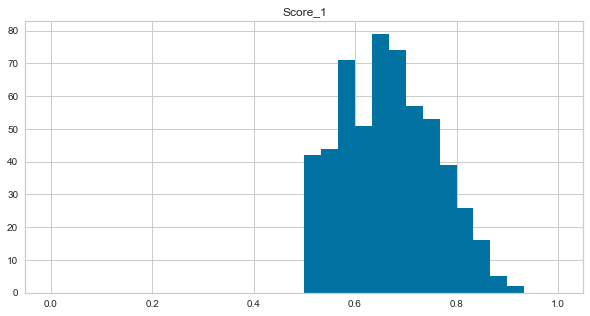

In [72]:
new_predictions = new_predictions.loc[new_predictions["productGrouping"] == "Full Season"]
new_predictions[new_predictions["Label"]==1][["Score_1"]].hist(bins=30, figsize=(10,5), range=[0,1])

### Let's plot the feature importances to see what features in the model are most predictive:

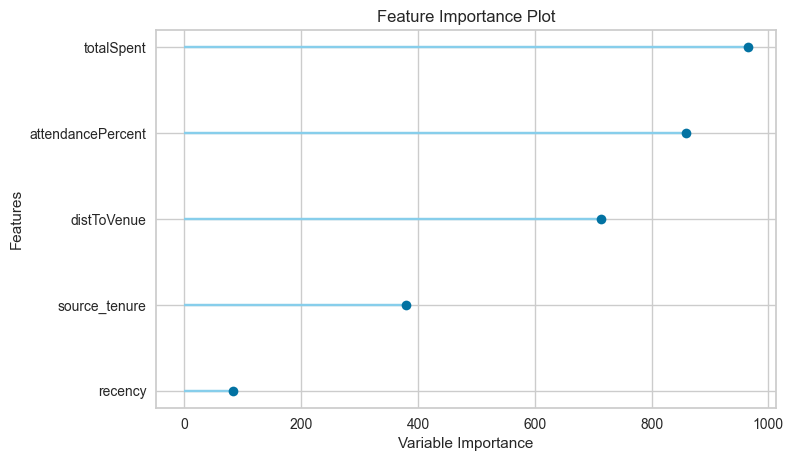

In [73]:
plot_model(best_model, plot='feature')

### Using a confusion matrix can also help us understand where the model is predicting correctly and where it's missing:

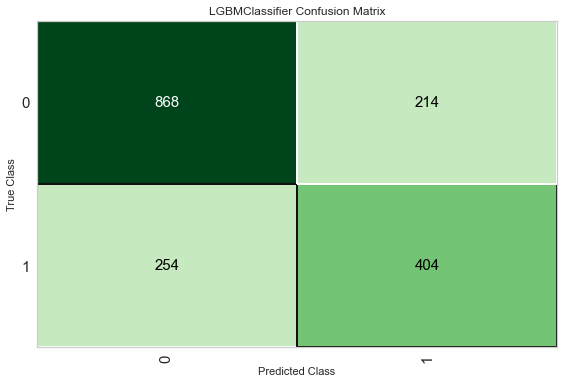

In [23]:
plot_model(best_model, plot='confusion_matrix')

### Let's also visualize the AUC (area under the curve) to get a sense of how our model is performing:

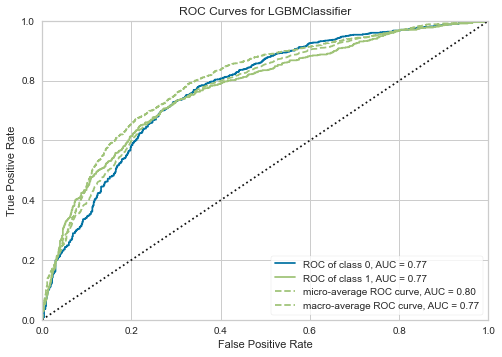

In [76]:
plot_model(best_model, plot="auc")

## Observations

* The model predictions are ~ 75% accurate 

* The Full Season ticket buyers fall into a Normal Distribution, as is expected.

* distToVenue is the third most important feature, with a variable importance ~ 75%

* The model made 3x as many correct predictions vs. incorrect predictions

## Conclusions

The distToVenue feature did prove to be a useful feature for model predictions. The next experiment will focus on altering the distToVenue feature to understand the impact (or non-impact) on model performance (i.e. does adding distance to the feature improve accuracy or have little to no impact).